[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
(43800, 8)


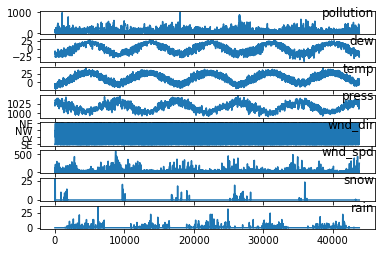

[[129.   -16.    -4.   ...   1.79   0.     0.  ]
 [148.   -15.    -4.   ...   2.68   0.     0.  ]
 [159.   -11.    -5.   ...   3.57   0.     0.  ]
 ...
 [ 10.   -22.    -3.   ... 242.7    0.     0.  ]
 [  8.   -22.    -4.   ... 246.72   0.     0.  ]
 [ 12.   -21.    -3.   ... 249.85   0.     0.  ]]
(43800, 8)
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
...          ...        ...        ...        ...        ...        ...   
43795   0.010060   0.264706   0.278689   0.763638   0.333333   0.385730   
43796   0.008048   0.250000   0.278689   0.781818   0.333333   0.395659   
43797   0.0100

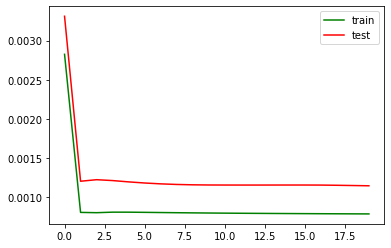

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


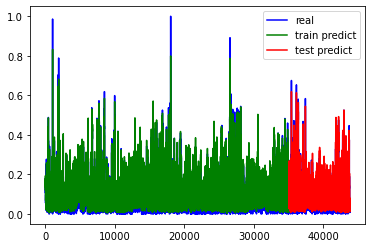

In [5]:
# 根据8个特征维度预测PM指数,使用的是LSTM
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from itertools import chain
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error


"""
给定输入、输出序列的长度
data: 观察序列 n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1， n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# 加载数据
dataset = read_csv('polluted.csv', header=0, index_col=0)
values = dataset.values
print(values)
print(values.shape)

# 可视化的列表
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# 探索数据
#plt.figure()
for group in range(8):
	plt.subplot(8, 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()


# 将分类特征wnd_dir 进行标签编码，0，1，2，3
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
print(values)

# 0-1规范化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

# 时间序列数据转换监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

# 训练集80%，测试集20%
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# :-1表示从0到数组最后一位，-1表示数组最后一位
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)

# 转换成3D格式 [样本数, 时间步, 特征数]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X)
#print(test_X)

# 设置网络模型
model = Sequential()
print('shape = ', train_X.shape)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1,8, train_X.shape = (35039, 1, 8)
print(test_X.shape[2])
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# 模型训练, epoch =20
result = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# 预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# 绘制损失
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')
plt.show()
print(model.summary())

# 呈现结果
def plot_img(source_data_set, train_predict, test_predict):
    # 蓝色原始数据
    plt.plot(source_data_set[:, -1], label='real', c='b')
    # 绿色 -- 训练数据
    plt.plot([x for x in train_predict], label='train predict', c='g')
    # 红色 --- 预测结果
    plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test predict', c='r')
    plt.legend()
    plt.show()

# 对比
plot_img(values, train_predict, test_predict)
